# Preparation

In [1]:
# --- Mount Google Drive to save models/checkpoints ---
from google.colab import drive
drive.mount('/content/drive')

# Where to save outputs
SAVE_DIR = "/content/drive/MyDrive/rtk_resnet"
import os
os.makedirs(SAVE_DIR, exist_ok=True)
print("SAVE_DIR:", SAVE_DIR)


Mounted at /content/drive
SAVE_DIR: /content/drive/MyDrive/rtk_resnet


In [2]:
# Install latest torch/vision (Colab usually has them)
!pip -q install --upgrade torch torchvision torchaudio


In [3]:
# Install kaggle and download the dataset
!pip -q install kaggle kagglehub

from google.colab import files
print("👉 Upload your kaggle.json (create from https://www.kaggle.com/settings/account)")
files.upload()  # select kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

import kagglehub
rtk_path = kagglehub.dataset_download("tallwinkingstan/road-traversing-knowledge-rtk-dataset")
print("Path to dataset files:", rtk_path)


👉 Upload your kaggle.json (create from https://www.kaggle.com/settings/account)


Saving kaggle.json to kaggle.json


100%|██████████| 723M/723M [00:15<00:00, 48.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/tallwinkingstan/road-traversing-knowledge-rtk-dataset/versions/1


# Data Preparation

In [4]:
import os, shutil, random
from pathlib import Path
random.seed(42)

# Try to locate the root RTK directory (case/typo tolerant)
candidates = [
    "RTK_Dataset", "RTK_dataset", "RTK_dataset/",
    "RTK_Dataset/", "RTK_dataset/RTK_Dataset", "RTK_Dataset/RTK_dataset"
]
DATASET_DIR = None
for c in candidates:
    p = os.path.join(rtk_path, c)
    if os.path.isdir(p):
        DATASET_DIR = p
        break

# If none of the above worked, try directly scanning one level down
if DATASET_DIR is None:
    for name in os.listdir(rtk_path):
        full = os.path.join(rtk_path, name)
        if os.path.isdir(full) and "rtk" in name.lower():
            DATASET_DIR = full
            break

print("Detected DATASET_DIR:", DATASET_DIR)
assert DATASET_DIR and os.path.isdir(DATASET_DIR), "Could not find RTK dataset folder. Inspect rtk_path printed above."

# Build a tolerant mapping for source → target class
def first_existing(*parts):
    """Return the first subpath that actually exists inside DATASET_DIR."""
    for rel in parts:
        full = os.path.join(DATASET_DIR, rel)
        if os.path.isdir(full):
            return rel
    return None

label_map = {}

# Asphalt
label_map[first_existing("asphalt/asphaltGood", "asphalt/Good", "asphalt/good")] = "asphalt_good"
label_map[first_existing("asphalt/asphaltRegular", "asphalt/Regular", "asphalt/regular")] = "asphalt_regular"
label_map[first_existing("asphalt/asphaltBad", "asphalt/Bad", "asphalt/bad")] = "asphalt_bad"

# Paved
label_map[first_existing("paved/pavedRegular", "paved/Regular", "paved/regular")] = "paved_regular"
label_map[first_existing("paved/pavedBad", "paved/Bad", "paved/bad")] = "paved_bad"

# Unpaved (handle common 'upaved' typo)
label_map[first_existing("unpaved/unpavedRegular", "upaved/unpavedRegular", "unpaved/Regular", "upaved/Regular", "unpaved/regular")] = "unpaved_regular"
label_map[first_existing("unpaved/unpavedBad", "upaved/unpavedBad", "unpaved/Bad", "upaved/Bad", "unpaved/bad")] = "unpaved_bad"

# Clean None keys if any didn't exist
label_map = {k:v for k,v in label_map.items() if k is not None}
print("Resolved source → target classes:")
for k,v in label_map.items():
    print(" ", k, "→", v)

expected_targets = {
    "asphalt_good","asphalt_regular","asphalt_bad",
    "paved_regular","paved_bad",
    "unpaved_regular","unpaved_bad"
}
assert set(label_map.values()) == expected_targets, f"Missing classes. Got {set(label_map.values())}"

# Output dir
OUTPUT_DIR = "/content/prepared_dataset"
for split in ["train", "val", "test"]:
    for cls in expected_targets:
        Path(f"{OUTPUT_DIR}/{split}/{cls}").mkdir(parents=True, exist_ok=True)

train_ratio, val_ratio, test_ratio = 0.70, 0.15, 0.15

def split_and_copy(src_dir, dst_label):
    files = [f for f in os.listdir(src_dir) if not f.startswith(".")]
    random.shuffle(files)
    n = len(files)
    n_train = int(n*train_ratio)
    n_val   = int(n*val_ratio)
    splits = {
        "train": files[:n_train],
        "val":   files[n_train:n_train+n_val],
        "test":  files[n_train+n_val:]
    }
    for split, split_files in splits.items():
        for f in split_files:
            src = os.path.join(src_dir, f)
            dst = os.path.join(OUTPUT_DIR, split, dst_label, f)
            if os.path.isfile(src):
                shutil.copy(src, dst)

# Do the split
for rel_src, tgt in label_map.items():
    split_and_copy(os.path.join(DATASET_DIR, rel_src), tgt)

print("✅ Prepared at:", OUTPUT_DIR)

# Show quick counts
from collections import Counter
def count_images(root):
    counts = {}
    for split in ["train","val","test"]:
        c = Counter()
        for cls in expected_targets:
            d = os.path.join(root, split, cls)
            c[cls] = len([x for x in os.listdir(d) if not x.startswith(".")])
        counts[split] = dict(c)
    return counts

counts = count_images(OUTPUT_DIR)
counts


Detected DATASET_DIR: /root/.cache/kagglehub/datasets/tallwinkingstan/road-traversing-knowledge-rtk-dataset/versions/1/RTK_Dataset
Resolved source → target classes:
  asphalt/asphaltGood → asphalt_good
  asphalt/asphaltRegular → asphalt_regular
  asphalt/asphaltBad → asphalt_bad
  paved/pavedRegular → paved_regular
  paved/pavedBad → paved_bad
  upaved/unpavedRegular → unpaved_regular
  upaved/unpavedBad → unpaved_bad
✅ Prepared at: /content/prepared_dataset


{'train': {'unpaved_bad': 415,
  'paved_bad': 86,
  'asphalt_good': 1384,
  'asphalt_bad': 324,
  'paved_regular': 226,
  'unpaved_regular': 557,
  'asphalt_regular': 587},
 'val': {'unpaved_bad': 88,
  'paved_bad': 18,
  'asphalt_good': 296,
  'asphalt_bad': 69,
  'paved_regular': 48,
  'unpaved_regular': 119,
  'asphalt_regular': 125},
 'test': {'unpaved_bad': 90,
  'paved_bad': 20,
  'asphalt_good': 298,
  'asphalt_bad': 71,
  'paved_regular': 50,
  'unpaved_regular': 120,
  'asphalt_regular': 127}}



# ResNET training

In [5]:
import os, json, time, numpy as np
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms, models

from sklearn.metrics import classification_report, confusion_matrix

DATA_DIR = OUTPUT_DIR  # from previous cell
MODEL_OUT = os.path.join(SAVE_DIR, "resnet18_rtk_best.pth")
LABELS_JSON = os.path.join(SAVE_DIR, "class_names.json")

IMG_SIZE   = 224
BATCH_SIZE = 32
EPOCHS     = 20
LR         = 3e-4
WEIGHT_DECAY = 1e-4
NUM_WORKERS  = 2
SEED = 42

torch.manual_seed(SEED); np.random.seed(SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# Transforms
train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.ColorJitter(0.3,0.3,0.2,0.05)], p=0.5),
    transforms.RandomAffine(degrees=10, translate=(0.05,0.05), scale=(0.95,1.05)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])
eval_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

# Datasets
train_ds = datasets.ImageFolder(os.path.join(DATA_DIR, "train"), transform=train_tf)
val_ds   = datasets.ImageFolder(os.path.join(DATA_DIR, "val"),   transform=eval_tf)
test_ds  = datasets.ImageFolder(os.path.join(DATA_DIR, "test"),  transform=eval_tf)

# Class names
class_to_idx = train_ds.class_to_idx
idx_to_class = {v:k for k,v in class_to_idx.items()}
class_names = [idx_to_class[i] for i in range(len(idx_to_class))]
print("Classes:", class_names)

with open(LABELS_JSON, "w") as f:
    json.dump(class_names, f, indent=2)

# Weighted sampler
labels = [y for _, y in train_ds.samples]
class_counts = np.bincount(labels, minlength=len(class_names)).astype(np.float32)
class_weights = 1.0 / np.maximum(class_counts, 1)
class_weights = class_weights / class_weights.sum() * len(class_weights)
sample_weights = [class_weights[y] for y in labels]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# Loaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# Model
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
in_feats = model.fc.in_features
model.fc = nn.Linear(in_feats, len(class_names))
model.to(device)

# Loss (also class-weighted)
ce_weights = torch.tensor(class_weights, dtype=torch.float32, device=device)
criterion = nn.CrossEntropyLoss(weight=ce_weights)

optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))

def run_epoch(loader, train_mode=True):
    model.train(train_mode)
    total, correct, running = 0, 0, 0.0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)

        if train_mode:
            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=(device=="cuda")):
                logits = model(imgs)
                loss = criterion(logits, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            with torch.no_grad():
                logits = model(imgs)
                loss = criterion(logits, labels)

        running += loss.item() * imgs.size(0)
        pred = logits.argmax(1)
        correct += (pred == labels).sum().item()
        total += imgs.size(0)
    return running/total, correct/total

best_val_acc, bad, patience = 0.0, 0, 5
for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    tr_loss, tr_acc = run_epoch(train_loader, True)
    va_loss, va_acc = run_epoch(val_loader, False)
    print(f"[{epoch:02d}/{EPOCHS}] train_loss={tr_loss:.4f} acc={tr_acc:.4f} | val_loss={va_loss:.4f} acc={va_acc:.4f} ({time.time()-t0:.1f}s)")
    if va_acc > best_val_acc:
        best_val_acc = va_acc
        torch.save({"model_state": model.state_dict(), "class_names": class_names, "val_acc": best_val_acc}, MODEL_OUT)
        print(f"  ✔ saved best to {MODEL_OUT} (val_acc {best_val_acc:.4f})")
        bad = 0
    else:
        bad += 1
        if bad >= patience:
            print("Early stopping.")
            break

# Load best and evaluate on test
ckpt = torch.load(MODEL_OUT, map_location=device)
model.load_state_dict(ckpt["model_state"])

@torch.no_grad()
def eval_full(loader):
    model.eval()
    ys, ps = [], []
    for x, y in loader:
        x = x.to(device)
        logits = model(x)
        p = logits.argmax(1).cpu().numpy().tolist()
        ys.extend(y.numpy().tolist())
        ps.extend(p)
    return np.array(ys), np.array(ps)

y_true, y_pred = eval_full(test_loader)
print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

print("Confusion matrix (rows=true, cols=pred):")
print(confusion_matrix(y_true, y_pred))


Device: cuda
Classes: ['asphalt_bad', 'asphalt_good', 'asphalt_regular', 'paved_bad', 'paved_regular', 'unpaved_bad', 'unpaved_regular']
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 176MB/s]
/tmp/ipython-input-982907961.py:81: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))
/tmp/ipython-input-982907961.py:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


[01/20] train_loss=0.2867 acc=0.8575 | val_loss=0.3641 acc=0.8545 (33.4s)
  ✔ saved best to /content/drive/MyDrive/rtk_resnet/resnet18_rtk_best.pth (val_acc 0.8545)
[02/20] train_loss=0.0979 acc=0.9436 | val_loss=0.0963 acc=0.9712 (34.1s)
  ✔ saved best to /content/drive/MyDrive/rtk_resnet/resnet18_rtk_best.pth (val_acc 0.9712)
[03/20] train_loss=0.0533 acc=0.9746 | val_loss=0.0753 acc=0.9699 (33.0s)
[04/20] train_loss=0.0419 acc=0.9765 | val_loss=0.0555 acc=0.9777 (31.6s)
  ✔ saved best to /content/drive/MyDrive/rtk_resnet/resnet18_rtk_best.pth (val_acc 0.9777)
[05/20] train_loss=0.0328 acc=0.9846 | val_loss=0.0510 acc=0.9895 (34.3s)
  ✔ saved best to /content/drive/MyDrive/rtk_resnet/resnet18_rtk_best.pth (val_acc 0.9895)
[06/20] train_loss=0.0546 acc=0.9807 | val_loss=0.0508 acc=0.9843 (32.4s)
[07/20] train_loss=0.0579 acc=0.9746 | val_loss=0.1227 acc=0.9620 (31.5s)
[08/20] train_loss=0.0983 acc=0.9614 | val_loss=0.1028 acc=0.9672 (31.7s)
[09/20] train_loss=0.0457 acc=0.9763 | val_l

# Export TorchScript & ONNX

In [6]:
# Exports you can use later for mobile or interop
dummy = torch.randn(1, 3, IMG_SIZE, IMG_SIZE, device=device)
model.eval()

scripted = torch.jit.trace(model, dummy)
ts_path = os.path.join(SAVE_DIR, "resnet18_rtk_scripted.pt")
scripted.save(ts_path)
print("Saved TorchScript:", ts_path)

try:
    torch.onnx.export(model, dummy, os.path.join(SAVE_DIR, "resnet18_rtk.onnx"),
                      input_names=["input"], output_names=["logits"],
                      opset_version=12, do_constant_folding=True)
    print("Saved ONNX:", os.path.join(SAVE_DIR, "resnet18_rtk.onnx"))
except Exception as e:
    print("ONNX export skipped:", e)


Saved TorchScript: /content/drive/MyDrive/rtk_resnet/resnet18_rtk_scripted.pt


/tmp/ipython-input-3740408513.py:11: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(model, dummy, os.path.join(SAVE_DIR, "resnet18_rtk.onnx"),


ONNX export skipped: Module onnx is not installed!


# Single-image prediction helper

In [13]:
import json
from PIL import Image
from torchvision import transforms
import torch.nn as nn
import random

# Load labels & model
with open(LABELS_JSON, "r") as f:
    class_names = json.load(f)

model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, len(class_names))
ckpt = torch.load(MODEL_OUT, map_location=device)
model.load_state_dict(ckpt["model_state"])
model.to(device).eval()

# Preprocess
infer_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

def predict_image(img_path):
    img = Image.open(img_path).convert("RGB")
    x = infer_tf(img).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1).cpu().numpy().squeeze()
    idx = int(probs.argmax())
    label = class_names[idx]
    return label, float(probs[idx]), {name: float(p) for name,p in zip(class_names, probs)}

# Example:
rand_class = random.choice(class_names)
rand_img = random.choice(os.listdir(os.path.join(OUTPUT_DIR, "test", rand_class)))
test_img = os.path.join(OUTPUT_DIR, "test", rand_class, rand_img)

# Run prediction
label, conf, dist = predict_image(test_img)
print("Image:", test_img)
print("Pred:", label, "(conf {:.3f})".format(conf))


Image: /content/prepared_dataset/test/asphalt_good/000001542.png
Pred: asphalt_good (conf 1.000)


# Test on IRL picture

In [14]:
from google.colab import files
uploaded = files.upload()
custom_img_path = list(uploaded.keys())[0]
print("Uploaded:", custom_img_path)

Saving test1.jpg to test1.jpg
Uploaded: test1.jpg


In [17]:
uploaded = files.upload()
custom_img_path2 = list(uploaded.keys())[0]
print("Uploaded:", custom_img_path2)

Saving test3.jpg to test3.jpg
Uploaded: test3.jpg


In [15]:
label, conf, dist = predict_image(custom_img_path)

print("Custom Image:", custom_img_path)
print("Prediction:", label, f"(conf {conf:.3f})")

Custom Image: test1.jpg
Prediction: asphalt_regular (conf 0.712)


In [18]:
label, conf, dist = predict_image(custom_img_path2)

print("Custom Image:", custom_img_path2)
print("Prediction:", label, f"(conf {conf:.3f})")

Custom Image: test3.jpg
Prediction: asphalt_good (conf 0.859)


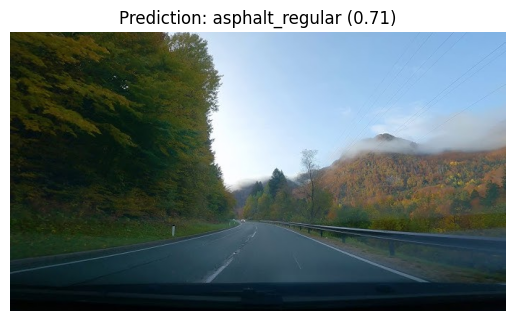

In [16]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread(custom_img_path)
plt.imshow(img)
plt.axis("off")
plt.title(f"Prediction: {label} ({conf:.2f})")
plt.show()

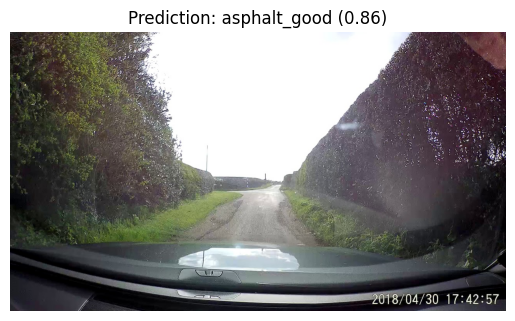

In [19]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread(custom_img_path2)
plt.imshow(img)
plt.axis("off")
plt.title(f"Prediction: {label} ({conf:.2f})")
plt.show()